In [1]:
import torch
from torchvision import transforms as T, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from PIL import Image
import random
import os
from pathlib import Path
import json

device = torch.device("cuda")

%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

torch.autograd.set_grad_enabled(False) # disable gradient calculation

# Extract image features

In [2]:
EXTRACTOR_MODEL = "../extraction.pth"
IMAGES_DIR = "../data/xishen/A_one_shot_recognition/"

extractor = torch.load(EXTRACTOR_MODEL, map_location=device).eval()

In [3]:
norm_vals = ([ 0.75,0.70,0.65],[ 0.14,0.15,0.16])

tforms_val = T.Compose([
    T.Resize((352, 352)),
    T.ToTensor(),
    T.Normalize(mean=norm_vals[0], std=norm_vals[1]),
])

In [4]:
test_dataset = ImageFolder(IMAGES_DIR, transform=tforms_val)

SPATIALLY_AWARE_NORM = False
SPATIALLY_AVERAGED = False

# process all the data
ref_features = []
dataloader = DataLoader(test_dataset, batch_size=60, shuffle=False, num_workers=4)

FLIP_ROTATIONS = [
    (False, 0), # 0
    (False, 1), # 90
    (False, 2), # 180
    (False, 3), # 270
    ([3], 0), # hflip
]

for flip, rot in FLIP_ROTATIONS:
    for imgs, cls in tqdm(dataloader):
        if flip:
            imgs = torch.flip(imgs, flip)
        if rot:
            imgs = torch.rot90(imgs, rot, [2, 3])

        f = extractor(imgs.to(device))
        f = f.reshape(imgs.shape[0], 512, -1)

        if SPATIALLY_AWARE_NORM:
            f = torch.nn.functional.normalize(f, dim=1)

        if SPATIALLY_AVERAGED:
            f = f.mean(dim=2)

        f = f.flatten(1)
        ref_features.append(f)

ref_features = torch.cat(ref_features, dim=0)
ref_features = torch.nn.functional.normalize(ref_features, dim=1)
ref_features = ref_features.reshape(len(FLIP_ROTATIONS), len(test_dataset), -1)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Build similarity matrix

In [5]:
query_features = ref_features[:4] # all rotations
ref_features = ref_features[[0, 4]] # all flips

In [6]:
topk = 20
min_sim = 0.3
n_query_flips, n_queries = query_features.shape[:2]
n_compare_flips, n_compare, n_feats = ref_features.shape

# compute similarity
queries = torch.nn.functional.normalize(query_features, dim=-1).to(ref_features.dtype)
sim0 = torch.mm(
    queries.reshape((-1, n_feats)), ref_features.reshape((-1, n_feats)).T
)

# collapse flips and rotations
sim = sim0.reshape(n_query_flips, n_queries, n_compare_flips, n_compare)
best_qsim, best_qflip = sim.max(dim=0)
similarity, best_sflip = best_qsim.max(dim=1)

# remove diagonal
similarity.fill_diagonal_(-1)
tops = similarity.topk(topk, dim=1)

In [7]:
# save results
results = {
    "matches": [
        [
            {
                "similarity": ssim.item(),
                "best_source_flip": best_sflip[i, j].item(),
                "best_query_flip": best_qflip[i, best_sflip[i, j], j].item(),
                "query_index": i,
                "source_index": j.item(),
            }
            for (j, ssim) in (zip(tops.indices[i], tops.values[i]))
            if ssim > min_sim
        ]
        for i in range(n_queries)
    ],
    "query_flips": [None, "rot90", "rot180", "rot270"],
}

with open("similarity.json", "w") as target:
    json.dump(results, target)

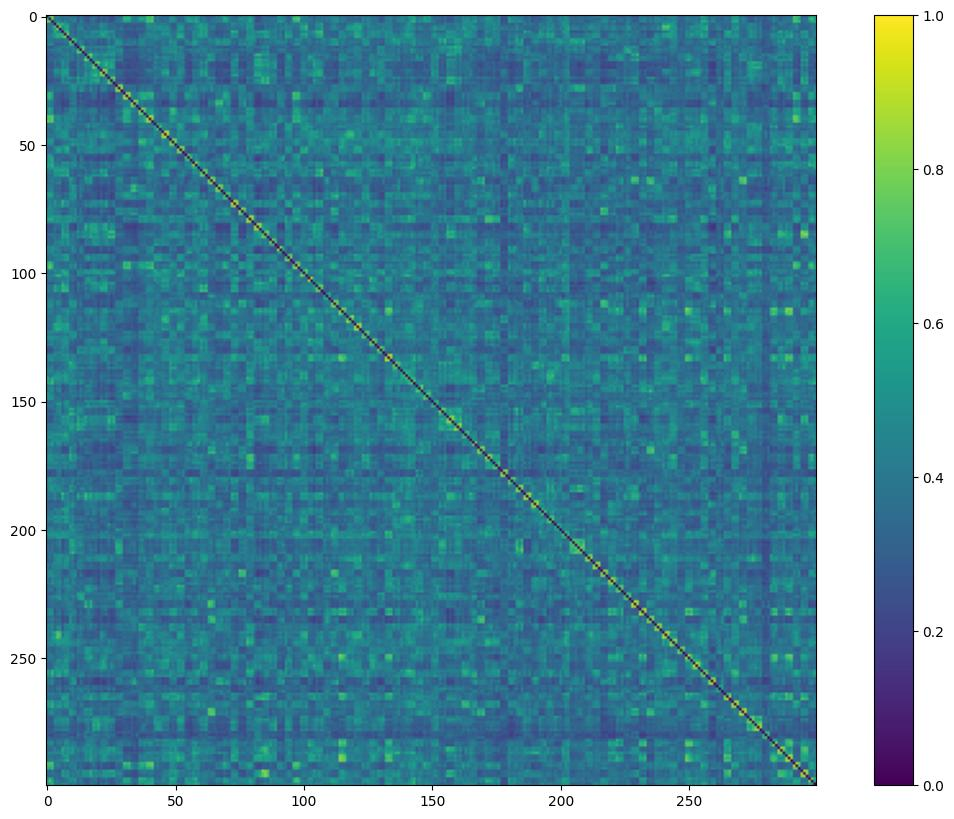

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.imshow(similarity.T.cpu().numpy(), cmap="viridis", vmin=0, vmax=1)
plt.colorbar()
plt.show()

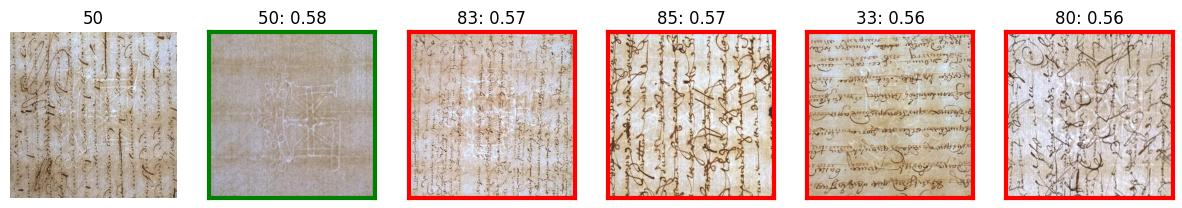

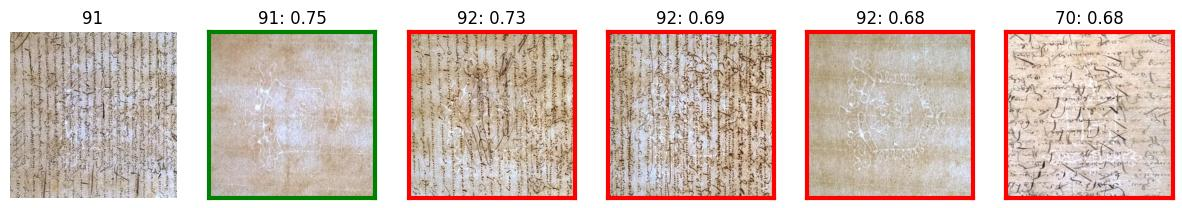

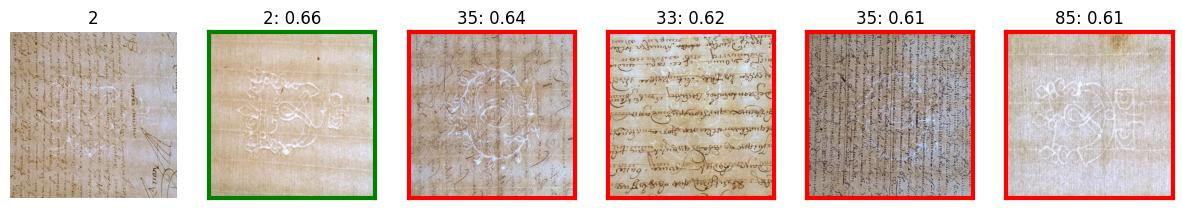

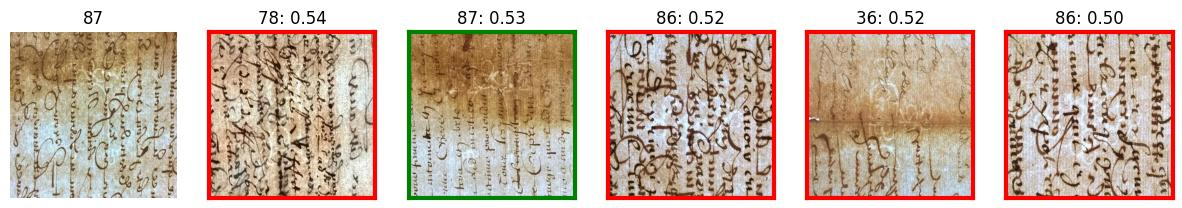

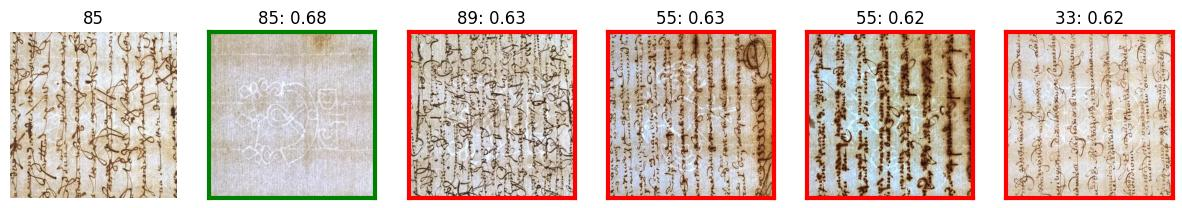

In [9]:
N = 5
for j in random.sample(range(similarity.size(0)), 5):
    # get the top 5 most similar images
    top5 = torch.topk(similarity[j], N+1).indices[1:]
    # plot the images, the first one is the query
    plt.figure(figsize=(15, 5))
    plt.subplot(1, N+1, 1)
    f, c = test_dataset.samples[j]
    plt.imshow(Image.open(f))
    plt.axis("off")
    of = Path(f).parent.name
    plt.title(f"{c}")

    for i, idx in enumerate(top5):
        ax = plt.subplot(1, N+1, i+2)
        f, kc = test_dataset.samples[idx]
        plt.imshow(Image.open(f))
        # outline red if the class is different
        color = "red" if c != kc % len(test_dataset.classes) else "green"
        for spine in plt.gca().spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
        
        of = Path(f).parent.name
        plt.title(f"{kc}: {similarity[j, idx]:.2f}")
        # hide axis ticks but not axis
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()